In [4]:
from geopy.geocoders import Nominatim
import numpy as np 
import pandas as pd # library for data analsysis
from haversine import haversine, Unit
import matplotlib.pyplot as plt

In [5]:
def get_darmstadt_location():
    geolocator = Nominatim(user_agent="somestring")
    address = 'Darmstadt, Deutschland'
    location = geolocator.geocode(address)
    return location

# Create grid of latitudes and longitudes
Function to create a grid around a given address

In [6]:
def create_grid(address,grid_size):
    location = get_darmstadt_location()
    #print(location.latitude)
    #print(location.longitude)
    bb_str = location.raw['boundingbox']
    bb_flt = [float(x) for x in bb_str]
    #print(bb_flt)
    latitudes = np.linspace(bb_flt[0],bb_flt[1],grid_size)
    longitudes = np.linspace(bb_flt[2],bb_flt[3],grid_size)
    #draw_map(location,latitudes,longitudes)
    return latitudes, longitudes

In [7]:
address = 'Darmstadt, Deutschland'
grid_size = 35
[latitudes, longitudes]=create_grid(address, grid_size)

Function to collect Foursquare location data

In [8]:
version ='20210214'
CLIENT_ID = 'xxx' # your Foursquare ID
CLIENT_SECRET = 'xxx' # your Foursquare Secret
def get_search(latitude,longitude,limit):
    import json, requests
    url = 'https://api.foursquare.com/v2/venues/search'
    params = dict(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        v=version,
        ll='{},{}'.format(latitude,longitude),
        llAcc=1,
        altAcc=144,
        limit=limit,
    )
    resp = requests.get(url=url, params=params)
    all_results =  json.loads(resp.text)

    if 'venues' in all_results['response']:
        venues = all_results['response']['venues']
        return venues

    return dict()

# Get data
Function to create initial data frame with all data found using Foursquare based on the grid of latitudes and longitudes

In [9]:
def create_dataframe(latitudes,longitudes,radius):
    venues_list = []
    count_no_venues = 0
    segment_id = 0
    segment_id_to_latlng = dict()
    for x in latitudes:
        for y in longitudes:
            limit = 1000
            query = ''
            venues = get_search(x, y, limit)
            venues_to_add = []
            for v in venues:
                if len(v['categories'])>0:
                    x2=v['location']['lat']
                    y2=v['location']['lng']
                    if haversine((x,y),(x2,y2))<radius:
                        venues_to_add.append(
                            (segment_id,
                            x,
                            y,
                            v['name'],
                            v['location']['lat'],
                            v['location']['lng'],
                            v['categories'][0]['name']))
            if len(venues_to_add)>0:
                venues_list.append(venues_to_add)
                print('segment: {} @({}, {}): {} venues.'.format(segment_id, x, y, len(venues_to_add)))
                segment_id_to_latlng[segment_id] = [x,y]
                segment_id += 1
            else:
                #print('segment: {} @({}, {}): No venues found.'.format(segment_id, x, y))
                count_no_venues += 1
        
    print("No venues found for ", count_no_venues, " grid points")
    df = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    df.columns = ['segment_id','segment_lat', 'segment_lng', 'venue', 'lat', 'lng', 'category']
    return df, segment_id_to_latlng


Create the dataframe using the grid and an approximate for every grid node 

In [10]:
radius = 0.4 # in km
df, segment_id_to_latlng = create_dataframe(latitudes,longitudes,radius)
print(df.shape)

segment: 0 @(49.7956794, 8.5581201): 6 venues.
segment: 1 @(49.7956794, 8.563755035294118): 2 venues.
segment: 2 @(49.7956794, 8.591929711764706): 1 venues.
segment: 3 @(49.7956794, 8.597564647058825): 4 venues.
segment: 4 @(49.7956794, 8.603199582352941): 6 venues.
segment: 5 @(49.7956794, 8.60883451764706): 7 venues.
segment: 6 @(49.7956794, 8.614469452941176): 2 venues.
segment: 7 @(49.7956794, 8.620104388235294): 1 venues.
segment: 8 @(49.7956794, 8.631374258823529): 1 venues.
segment: 9 @(49.7956794, 8.637009194117647): 1 venues.
segment: 10 @(49.7956794, 8.648279064705882): 4 venues.
segment: 11 @(49.7956794, 8.653914): 4 venues.
segment: 12 @(49.7956794, 8.665183870588235): 4 venues.
segment: 13 @(49.7956794, 8.670818805882353): 4 venues.
segment: 14 @(49.7956794, 8.676453741176472): 2 venues.
segment: 15 @(49.7956794, 8.682088676470588): 1 venues.
segment: 16 @(49.7956794, 8.732803094117648): 1 venues.
segment: 17 @(49.7956794, 8.738438029411766): 3 venues.
segment: 18 @(49.795

# Data cleaning and exploring
Drop duplicates

In [11]:
df.drop_duplicates(subset=['venue'], inplace=True)
print(df.shape)


(3928, 7)


How many different venue categories do we have ? 

In [17]:
all_cat = df['category'].unique()
print(np.sort(all_cat))
print(len(all_cat))

['Accessories Store' 'Adult Boutique' 'Adult Education Center'
 'Advertising Agency' 'African Restaurant' 'Airport' 'Alternative Healer'
 'American Restaurant' 'Animal Shelter' 'Antique Shop' 'Arcade'
 'Art Gallery' 'Art Museum' 'Arts & Crafts Store' 'Arts & Entertainment'
 'Asian Restaurant' 'Assisted Living' 'Astrologer' 'Athletics & Sports'
 'Auditorium' 'Australian Restaurant' 'Auto Dealership' 'Auto Garage'
 'Auto Workshop' 'Automotive Shop' 'BBQ Joint' 'Baby Store' 'Bagel Shop'
 'Bakery' 'Ballroom' 'Bank' 'Bar' 'Baseball Field' 'Baseball Stadium'
 'Basketball Court' 'Bathing Area' 'Bed & Breakfast' 'Beer Bar'
 'Beer Garden' 'Beer Store' 'Big Box Store' 'Bike Rental / Bike Share'
 'Bike Shop' 'Bike Trail' 'Bistro' 'Board Shop' 'Boarding House'
 'Boat Rental' 'Bookstore' 'Botanical Garden' 'Boutique' 'Bowling Alley'
 'Bowling Green' 'Boxing Gym' 'Breakfast Spot' 'Brewery' 'Bridal Shop'
 'Bridge' 'Buffet' 'Building' 'Burger Joint' 'Burrito Place' 'Bus Line'
 'Bus Station' 'Bus Stop'

In [21]:
import re
def vis_categories(df,rowmin=0,rowmax=10):
    df2=df.value_counts(subset='category').reset_index()
    df2.rename(columns={0:'counts'},inplace=True)
    #print(df2)
    df2.iloc[rowmin:rowmax].plot.barh(x='category',y='counts')
    plt.tight_layout()
    plt.gca().invert_yaxis()
    plt.show()


In [13]:
location=get_darmstadt_location()
print(location)


Darmstadt, Hessen, Deutschland


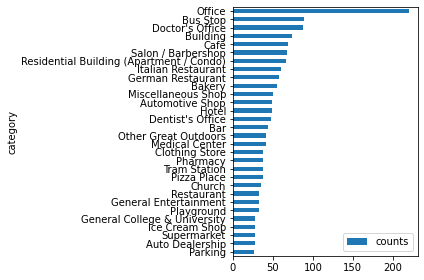

In [14]:
vis_categories(df,0,30)


Since there are too many venue categories, we aggregate similar ones into broader categories

In [19]:
def childcare(df):
    pattern ="high school|"\
        "middle school|"\
        "elementary school|"\
        "general college & university|"\
        "playground|"\
        "daycare|"\
        "nursery|"\
        "language school"
    add = df['category'].str.contains(pattern, flags=re.IGNORECASE)
    print("childcare: ", add.value_counts().loc[True])
    return add

def shopping(df):
    pattern = "mall|clothing|sporting goods|flower|tailor|"\
        "gift shop|record shop|hobby shop|bike shop|bookstore"\
        "jewelry|shoe store|shoe repair"
    add = df['category'].str.contains(pattern, case=False)
    print("shopping: ", add.value_counts().loc[True])
    return add

def basics(df):
    pattern = "wine shop|bakery|supermarket|grocery|"\
        "drink shop|vegetable|butcher|liquor store|coffee roaster|drugstore|barbershop"
    add = df['category'].str.contains(pattern, case=False)
    print("basics: ", add.value_counts().loc[True])
    return add

def health(df):
    pattern = "hospital|doctor|pharmacy|dentist|medical"
    add = df['category'].str.contains(pattern, case=False)
    print("health: ", add.value_counts().loc[True])
    return add

def catering(df):
    pattern = "restaurant|café|cafeteria|fish & chips"\
        "|burger|bagel|ice cream shop"\
        "|pizza|coffee shop|taverna|gastropub|steakhouse|bbq joint"
    add = df['category'].str.contains(pattern, case=False)
    add |= df['category'].str.match("\w*\s?Bar")
    print("catering: ", add.value_counts().loc[True])
    return add

def entertainment(df):
    pattern = "jazz|concert"\
        "|entertainment|theater|irish pub|nightlife|nightclub|lounge"
    add = df['category'].str.contains(pattern, case=False)
    add |= df['category'].str.match("\w*\s?Bar")
    add |= df['category'].str.match("\w*\s?Pub")
    print("entertainment: ", add.value_counts().loc[True])
    return add

def sports(df):
    pattern = "tennis|baseball|basketball|fitness|pool"\
            "|gymnastics|football|rugby|soccer|stadium|sports club|golf|gym"
    add = df['category'].str.contains(pattern, case=False)
    print("sports: ", add.value_counts().loc[True])
    return add

def outdoor(df):
    pattern = "scenic|nature preserve|national park|outdoors|river|skate park|zoo|castle|lake|farm"
    add = df['category'].str.contains(pattern, case=False)
    add |= df['category'].str.fullmatch("park",case=False)
    print("outdoor: ", add.value_counts().loc[True])
    return add



In [23]:
childcare_s = childcare(df)
sports_s = sports(df)
entertainment_s = entertainment(df)
catering_s = catering(df)
health_s = health(df)
shopping_s = shopping(df)
basics_s = basics(df)
outdoor_s = outdoor(df)

all = childcare_s | sports_s | entertainment_s | health_s | shopping_s | basics_s | outdoor_s | catering_s

new_column_name = 'my_cat'
df.loc[childcare_s, new_column_name] = 'childcare'
df.loc[sports_s, new_column_name] = 'sports'
df.loc[entertainment_s, new_column_name] = 'entertainment'
df.loc[catering_s, new_column_name] = 'catering'
df.loc[health_s, new_column_name] = 'health'
df.loc[shopping_s, new_column_name] = 'shopping'
df.loc[basics_s,new_column_name] = 'basics'
df.loc[outdoor_s, new_column_name] = 'outdoor'


childcare:  83
sports:  123
entertainment:  206
catering:  658
health:  234
shopping:  148
basics:  215
outdoor:  115


In [24]:
df2=df[all]

In [25]:
def group_by_segment(df):
    # one hot encoding
    onehot = pd.get_dummies(df[['my_cat']])
    # add neighborhood column back to dataframe
    onehot[['segment_id']] = df[['segment_id']]
    #onehot[['segment_lat']] = df[['segment_lat']]
    #onehot[['segment_lng']] = df[['segment_lng']]
    # move neighborhood column to the first column
    fixed_columns = list(onehot.columns[-1:]) + list(onehot.columns[:-1])
    onehot = onehot[fixed_columns]
    #Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
    grouped = onehot.groupby('segment_id').sum().reset_index()
    return grouped


In [27]:
df3 = group_by_segment(df2)
# set number of clusters
grouped_clustering = df3.drop('segment_id', 1)


# Clustering

In [28]:
kclusters = 4
def do_kmeans(kclusters,df):
    from sklearn.cluster import KMeans
    clustering = KMeans(n_clusters=kclusters, random_state=0, n_init=30).fit(df)
    print("kmeans - number of iterations run: ",clustering.n_iter_)
    print("kmeans - inertia: ",clustering.inertia_)
    return clustering
        
clustering = do_kmeans(kclusters,grouped_clustering)
df3['cluster_label']=clustering.labels_


kmeans - number of iterations run:  13
kmeans - inertia:  2434.308915145002


# Results - visualization

In [42]:
import folium  # plotting library
def vis_clusters(location,kclusters,df,segment_to_latlng):
    # Matplotlib and associated plotting modules
    import matplotlib.cm as cm
    import matplotlib.colors as colors

    # viesualize the clusters
    # create map
    map_clusters = folium.Map(location=[location.latitude, location.longitude], zoom_start=12)
    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i * x) ** 2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]
    # add markers to the map
    markers_colors = []
    for segment_id,cluster_id in zip(df['segment_id'], df['cluster_label']):
        label = folium.Popup(str(segment_id) + ' Cluster ' + str(cluster_id), parse_html=True)
        loc = segment_to_latlng[segment_id]
        folium.CircleMarker(
            [loc[0], loc[1]],
            radius=5,
            popup=label,
            color=rainbow[cluster_id - 1],
            fill=True,
            fill_color=rainbow[cluster_id - 1],
            fill_opacity=0.7).add_to(map_clusters)
    return map_clusters



In [41]:
map = vis_clusters(get_darmstadt_location(),kclusters,df3,segment_id_to_latlng)
map

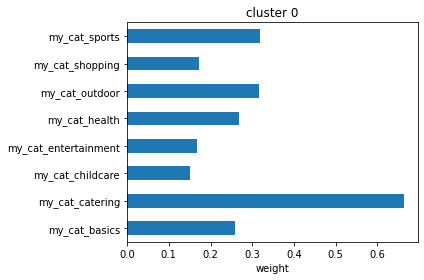

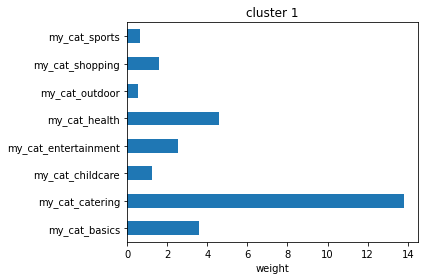

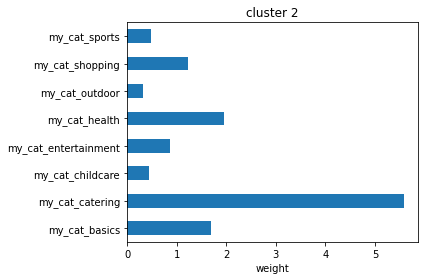

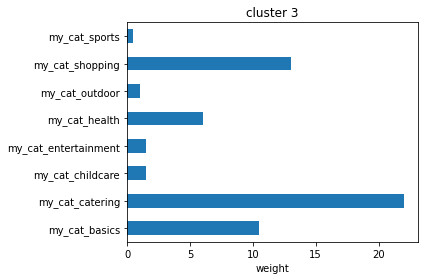

In [31]:
for cluster in range(0,kclusters):
    content = list(range(1, df3.shape[1]-1))
    df_cluster = df3.loc[df3['cluster_label'] == cluster, df3.columns[content]]
    df_cluster.mean().plot.barh()
    plt.xlabel('weight')
    plt.title('cluster '+str(cluster))
    plt.tight_layout()
    plt.show()
    #name = 'plots/cluster_'+str(cluster)
    #plt.savefig(name)
